This tutorial was implemented on Macbook pro (15-inch, 2018)

# Simulate scRNA-seq data

In [1]:
rm(list = ls())
library(splatter)
library(rhdf5)

i <- 1 ## set random seed
simulate <- function(nGroups=3, nGenes=2500, batchCells=1500, dropout=0) # change dropout to simulate various dropout rates
  {
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'
    
    group.prob <- rep(1, nGroups) / nGroups
    sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                         dropout.type="experiment", method=method,
                         seed=100+i, dropout.shape=-1, dropout.mid=dropout, de.facScale=0.25)
    
    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))
    
    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'
    
    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))
    
    list(sim=sim,
         counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
  }

sim <- simulate()
  
simulation <- sim$sim
counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

dropout.rate <- (sum(counts==0)-sum(truecounts==0))/sum(truecounts>0)
print("Dropout rate")
print(dropout.rate)
save(counts, geneinfo, cellinfo, truecounts, file=paste("splatter_simulate_data_", i, ".RData", sep=""))

X <- t(counts) ## counts with dropout
Y <- as.integer(substring(cellinfo$Group,6))
Y <- Y-1

h5createFile(paste("splatter_simulate_data_", i, ".h5", sep=""))
h5write(X, paste("splatter_simulate_data_", i, ".h5", sep=""),"X")
h5write(Y, paste("splatter_simulate_data_", i, ".h5", sep=""),"Y")

true.X <- t(truecounts) ## counts without dropout
h5createFile(paste("splatter_simulate_truedata_", i, ".h5", sep=""))
h5write(true.X, paste("splatter_simulate_truedata_", i, ".h5", sep=""),"X")
h5write(Y, paste("splatter_simulate_truedata_", i, ".h5", sep=""),"Y")

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    

[1] "Dropout rate"
[1] 0.1670475


[1] TRUE

Warning message in h5createDataset(h5loc, name, dim, storage.mode = storage.mode(obj), :
“You created a large dataset with compression and chunking. The chunk size is equal to the dataset dimensions. If you want to read subsets of the dataset, you should test smaller chunk sizes to improve read times. Turn off this warning with showWarnings=FALSE.”

[1] TRUE

Warning message in h5createDataset(h5loc, name, dim, storage.mode = storage.mode(obj), :
“You created a large dataset with compression and chunking. The chunk size is equal to the dataset dimensions. If you want to read subsets of the dataset, you should test smaller chunk sizes to improve read times. Turn off this warning with showWarnings=FALSE.”

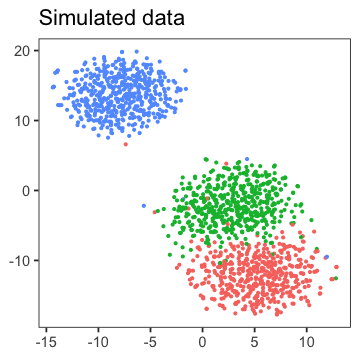

In [2]:
#### make tSNE plot for the simulated data
library(Rtsne)
library(ggplot2)
library(repr)
options(repr.plot.width=3, repr.plot.height=3)

X.normalized <- apply(X, 2, function(z) z/sum(z))
X.normalized <- log(X.normalized + 1)
tsne.X <- Rtsne(t(X.normalized), max_iter = 1000)
  
tsne_plot.X <- data.frame(`x-tsne` = tsne.X$Y[,1], `y-tsne` = tsne.X$Y[,2], 
                        truelabel = Y, check.names = F)
tsne_plot.X$truelabel <- factor(tsne_plot.X$truelabel, levels = c(0:max(Y)))

ggplot(tsne_plot.X) + geom_point(aes(x=`x-tsne`, y=`y-tsne`, color=truelabel), size=0.5) +
          labs(color='true label') +
          ggtitle("Simulated data") +
          theme_bw() +
          theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
                legend.key = element_rect(fill = 'white', colour = 'white'), legend.position="none",
                axis.title.y=element_blank(), axis.title.x=element_blank())

# Run scDeepCluster on the simulated data

In [1]:
"""
This part implements the scDeepCluster algoritm
"""

from time import time
import numpy as np
from keras.models import Model
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, GaussianNoise, Layer, Activation
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

from sklearn.cluster import KMeans
from sklearn import metrics

import h5py
import scanpy.api as sc
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
from loss import poisson_loss, NB, ZINB
from preprocess import read_dataset, normalize
import tensorflow as tf

from numpy.random import seed
seed(2211)
from tensorflow import set_random_seed
set_random_seed(2211)

MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size


def autoencoder(dims, noise_sd=0, init='glorot_uniform', act='relu'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        Model of autoencoder
    """
    n_stacks = len(dims) - 1
    # input
    sf_layer = Input(shape=(1,), name='size_factors')
    x = Input(shape=(dims[0],), name='counts')
    h = x
    h = GaussianNoise(noise_sd, name='input_noise')(h)
 
    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], kernel_initializer=init, name='encoder_%d' % i)(h)
        h = GaussianNoise(noise_sd, name='noise_%d' % i)(h)    # add Gaussian noise
        h = Activation(act)(h)
    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_hidden')(h)  # hidden layer, features are extracted from here

    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(h)

    # output
 
    pi = Dense(dims[0], activation='sigmoid', kernel_initializer=init, name='pi')(h)

    disp = Dense(dims[0], activation=DispAct, kernel_initializer=init, name='dispersion')(h)

    mean = Dense(dims[0], activation=MeanAct, kernel_initializer=init, name='mean')(h)

    output = ColWiseMultLayer(name='output')([mean, sf_layer])
    output = SliceLayer(0, name='slice')([output, disp, pi])

    return Model(inputs=[x, sf_layer], outputs=output)


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



class SCDeepCluster(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 noise_sd=0,
                 alpha=1.0,
                 ridge=0,
                 debug=False):

        super(SCDeepCluster, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.noise_sd = noise_sd
        self.alpha = alpha
        self.act = 'relu'
        self.ridge = ridge
        self.debug = debug
        self.autoencoder = autoencoder(self.dims, noise_sd=self.noise_sd, act = self.act)
        
        # prepare clean encode model without Gaussian noise
        ae_layers = [l for l in self.autoencoder.layers]
        hidden = self.autoencoder.input[0]
        for i in range(1, len(ae_layers)):
            if "noise" in ae_layers[i].name:
                next
            elif "dropout" in ae_layers[i].name:
                next
            else:
                hidden = ae_layers[i](hidden)
            if "encoder_hidden" in ae_layers[i].name:  # only get encoder layers
                break
        self.encoder = Model(inputs=self.autoencoder.input, outputs=hidden)

        pi = self.autoencoder.get_layer(name='pi').output
        disp = self.autoencoder.get_layer(name='dispersion').output
        mean = self.autoencoder.get_layer(name='mean').output
        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss

        clustering_layer = ClusteringLayer(self.n_clusters, alpha=self.alpha, name='clustering')(hidden)
        self.model = Model(inputs=[self.autoencoder.input[0], self.autoencoder.input[1]],
                           outputs=[clustering_layer, self.autoencoder.output])

        self.pretrained = False
        self.centers = []
        self.y_pred = []

    def pretrain(self, x, y, batch_size=256, epochs=200, optimizer='adam', ae_file='ae_weights.h5'):
        print('...Pretraining autoencoder...')
        self.autoencoder.compile(loss=self.loss, optimizer=optimizer)
        es = EarlyStopping(monitor="loss", patience=50, verbose=1)
        self.autoencoder.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, callbacks=[es])
        self.autoencoder.save_weights(ae_file)
        print('Pretrained weights are saved to ./' + str(ae_file))
        self.pretrained = True

    def load_weights(self, weights_path):  # load weights of scDeepCluster model
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  # extract features from before clustering layer
        return self.encoder.predict(x)

    def predict_clusters(self, x):  # predict cluster labels using the output of clustering layer
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):  # target distribution P which enhances the discrimination of soft label Q
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def fit(self, x_counts, sf, y, raw_counts, batch_size=256, maxiter=2e4, tol=1e-3, update_interval=140,
            ae_weights=None, save_dir='./results/scDeepCluster', loss_weights=[1,1], optimizer='adadelta'):

        self.model.compile(loss=['kld', self.loss], loss_weights=loss_weights, optimizer=optimizer)

        print('Update interval', update_interval)
        save_interval = int(x_counts.shape[0] / batch_size) * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: pretrain
        if not self.pretrained and ae_weights is None:
            print('...pretraining autoencoders using default hyper-parameters:')
            print('   optimizer=\'adam\';   epochs=200')
            self.pretrain(x, batch_size)
            self.pretrained = True
        elif ae_weights is not None:
            self.autoencoder.load_weights(ae_weights)
            print('ae_weights is loaded successfully.')

        # Step 2: initialize cluster centers using k-means
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict([x_counts, sf]))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 3: deep clustering
        # logging file
        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/scDeepCluster_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict([x_counts, sf], verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                self.y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(cluster_acc(y, self.y_pred), 5)
                    nmi = np.round(metrics.normalized_mutual_info_score(y, self.y_pred), 5)
                    ari = np.round(metrics.adjusted_rand_score(y, self.y_pred), 5)
                    loss = np.round(loss, 5)
                    logwriter.writerow(dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss[0], Lc=loss[1], Lr=loss[2]))
                    print('Iter-%d: ACC= %.4f, NMI= %.4f, ARI= %.4f;  L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (ite, acc, nmi, ari, loss[0], loss[1], loss[2]))

                # check stop criterion
                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            if (index + 1) * batch_size > x_counts.shape[0]:
                loss = self.model.train_on_batch(x=[x_counts[index * batch_size::], sf[index * batch_size:]],
                                                 y=[p[index * batch_size::], raw_counts[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=[x_counts[index * batch_size:(index + 1) * batch_size], 
                                                    sf[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    raw_counts[index * batch_size:(index + 1) * batch_size]])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save scDeepCluster model checkpoints
                print('saving model to: ' + save_dir + '/scDeepCluster_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/scDeepCluster_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to: ' + save_dir + '/scDeepCluster_model_final.h5')
        self.model.save_weights(save_dir + '/scDeepCluster_model_final.h5')
        
        return self.y_pred

Using TensorFlow backend.


In [5]:
#### Run scDeepCluster on the simulated data

optimizer1 = Adam(amsgrad=True)
optimizer2 = 'adadelta'

data_mat = h5py.File("splatter_simulate_data_1.h5")
x = np.array(data_mat['X'])
y = np.array(data_mat['Y'])

# preprocessing scRNA-seq read counts matrix
adata = sc.AnnData(x)
adata.obs['Group'] = y

adata = read_dataset(adata,
                 transpose=False,
                 test_split=False,
                 copy=True)

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

input_size = adata.n_vars

print('Sample size')
print(adata.X.shape)
print(y.shape)

x_sd = adata.X.std(0)
x_sd_median = np.median(x_sd)

update_interval = int(adata.X.shape[0]/256)


# Define scDeepCluster model
scDeepCluster = SCDeepCluster(dims=[input_size, 256, 64, 32], n_clusters=3, noise_sd=2.5)
print("autocoder summary")
scDeepCluster.autoencoder.summary()
print("model summary")
scDeepCluster.model.summary()

t0 = time()

# Pretrain autoencoders before clustering
scDeepCluster.pretrain(x=[adata.X, adata.obs.size_factors], y=adata.raw.X, batch_size=256, epochs=600, optimizer=optimizer1, ae_file='ae_weights.h5')

# begin clustering, time not include pretraining part.

gamma = 1. # set hyperparameter gamma
scDeepCluster.fit(x_counts=adata.X, sf=adata.obs.size_factors, y=y, raw_counts=adata.raw.X, batch_size=256, tol=0.001, maxiter=20000,
         update_interval=update_interval, ae_weights=None, save_dir='scDeepCluster', loss_weights=[gamma, 1], optimizer=optimizer2)

# Show the final results
y_pred = scDeepCluster.y_pred
acc = np.round(cluster_acc(y, scDeepCluster.y_pred), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, scDeepCluster.y_pred), 5)
ari = np.round(metrics.adjusted_rand_score(y, scDeepCluster.y_pred), 5)
print('Final: ACC= %.4f, NMI= %.4f, ARI= %.4f' % (acc, nmi, ari))
print('Clustering time: %d seconds.' % int(time() - t0))

### Autoencoder: Successfully preprocessed 2500 genes and 1500 cells.
Sample size
(1500, 2484)
(1500,)
autocoder summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
counts (InputLayer)             (None, 2484)         0                                            
__________________________________________________________________________________________________
input_noise (GaussianNoise)     (None, 2484)         0           counts[0][0]                     
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 256)          636160      input_noise[0][0]                
__________________________________________________________________________________________________
noise_0 (GaussianNoise)         (None, 256)          0           encoder_0[0][0]       

Epoch 1/600
1500/1500 [==============================] - 1s 851us/step - loss: 9.7845
Epoch 2/600
1500/1500 [==============================] - 1s 346us/step - loss: 3.7441
Epoch 3/600
1500/1500 [==============================] - 1s 344us/step - loss: 3.7206
Epoch 4/600
1500/1500 [==============================] - 1s 348us/step - loss: 3.2924
Epoch 5/600
1500/1500 [==============================] - 1s 350us/step - loss: 3.0128
Epoch 6/600
1500/1500 [==============================] - 1s 342us/step - loss: 2.9410
Epoch 7/600
1500/1500 [==============================] - 1s 350us/step - loss: 2.8771
Epoch 8/600
1500/1500 [==============================] - 1s 349us/step - loss: 2.8489
Epoch 9/600
1500/1500 [==============================] - 1s 344us/step - loss: 2.8185
Epoch 10/600
1500/1500 [==============================] - 1s 345us/step - loss: 2.7896
Epoch 11/600
1500/1500 [==============================] - 1s 350us/step - loss: 2.7715
Epoch 12/600
1500/1500 [============================

1500/1500 [==============================] - 0s 325us/step - loss: 2.4588
Epoch 189/600
1500/1500 [==============================] - 1s 342us/step - loss: 2.4565
Epoch 190/600
1500/1500 [==============================] - 1s 344us/step - loss: 2.4556
Epoch 191/600
1500/1500 [==============================] - 1s 336us/step - loss: 2.4577
Epoch 192/600
1500/1500 [==============================] - 1s 335us/step - loss: 2.4563
Epoch 193/600
1500/1500 [==============================] - 1s 344us/step - loss: 2.4552
Epoch 194/600
1500/1500 [==============================] - 1s 335us/step - loss: 2.4553
Epoch 195/600
1500/1500 [==============================] - 1s 335us/step - loss: 2.4546
Epoch 196/600
1500/1500 [==============================] - 1s 336us/step - loss: 2.4563
Epoch 197/600
1500/1500 [==============================] - 0s 328us/step - loss: 2.4550
Epoch 198/600
1500/1500 [==============================] - 0s 328us/step - loss: 2.4528
Epoch 199/600
1500/1500 [=====================

1500/1500 [==============================] - 1s 344us/step - loss: 2.4117
Epoch 375/600
1500/1500 [==============================] - 1s 340us/step - loss: 2.4091
Epoch 376/600
1500/1500 [==============================] - 0s 329us/step - loss: 2.4088
Epoch 377/600
1500/1500 [==============================] - 0s 333us/step - loss: 2.4089
Epoch 378/600
1500/1500 [==============================] - 0s 332us/step - loss: 2.4076
Epoch 379/600
1500/1500 [==============================] - 0s 326us/step - loss: 2.4076
Epoch 380/600
1500/1500 [==============================] - 1s 338us/step - loss: 2.4076
Epoch 381/600
1500/1500 [==============================] - 0s 333us/step - loss: 2.4083
Epoch 382/600
1500/1500 [==============================] - 1s 339us/step - loss: 2.4093
Epoch 383/600
1500/1500 [==============================] - 1s 339us/step - loss: 2.4073
Epoch 384/600
1500/1500 [==============================] - 1s 344us/step - loss: 2.4073
Epoch 385/600
1500/1500 [=====================

1500/1500 [==============================] - 1s 335us/step - loss: 2.4036
Epoch 561/600
1500/1500 [==============================] - 0s 333us/step - loss: 2.4037
Epoch 562/600
1500/1500 [==============================] - 1s 337us/step - loss: 2.4038
Epoch 563/600
1500/1500 [==============================] - 1s 339us/step - loss: 2.4031
Epoch 564/600
1500/1500 [==============================] - 1s 340us/step - loss: 2.4032
Epoch 565/600
1500/1500 [==============================] - 1s 335us/step - loss: 2.4034
Epoch 566/600
1500/1500 [==============================] - 1s 336us/step - loss: 2.4038
Epoch 567/600
1500/1500 [==============================] - 1s 338us/step - loss: 2.4036
Epoch 568/600
1500/1500 [==============================] - 1s 339us/step - loss: 2.4037
Epoch 569/600
1500/1500 [==============================] - 1s 337us/step - loss: 2.4038
Epoch 570/600
1500/1500 [==============================] - 0s 333us/step - loss: 2.4039
Epoch 571/600
1500/1500 [=====================

Clustering result:

Final: ACC= 0.9940, NMI= 0.9640, ARI= 0.9821

# Plot the latent space 

In [6]:
hidden_layer = scDeepCluster.model.get_layer(name='encoder_hidden').get_output_at(1)
hidden_output_model = Model(inputs = scDeepCluster.model.input, outputs = hidden_layer)
hidden_output = hidden_output_model.predict([adata.X, adata.obs.size_factors])
hidden_output = np.asarray(hidden_output)
np.savetxt('latent_output.csv', hidden_output, delimiter=",")

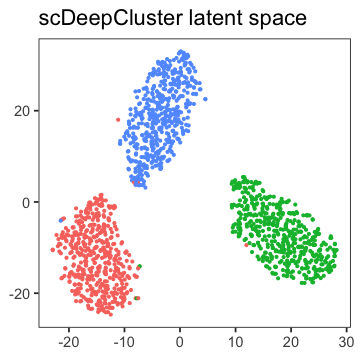

In [4]:
library(Rtsne)
library(ggplot2)
library(repr)
library(rhdf5)
options(repr.plot.width=3, repr.plot.height=3)

latent.dat <- read.table("latent_output.csv", header = F, sep = ",")
tsne.X <- Rtsne(latent.dat, max_iter = 1000)

Y <- h5read("splatter_simulate_data_1.h5", "Y")
tsne_plot.X <- data.frame(`x-tsne` = tsne.X$Y[,1], `y-tsne` = tsne.X$Y[,2], 
                        truelabel = Y, check.names = F)
tsne_plot.X$truelabel <- factor(tsne_plot.X$truelabel, levels = c(0:max(Y)))

ggplot(tsne_plot.X) + geom_point(aes(x=`x-tsne`, y=`y-tsne`, color=truelabel), size=0.5) +
          labs(color='true label') +
          ggtitle("scDeepCluster latent space") +
          theme_bw() +
          theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
                legend.key = element_rect(fill = 'white', colour = 'white'), legend.position="none",
                axis.title.y=element_blank(), axis.title.x=element_blank())